# Deep learning and AI methods
## Analyzing image data using convolution neural networks
* Instructor: [Krzysztof Podgorski](https://krys.neocities.org),  [Statistics, Lund University, LUSEM](https://www.stat.lu.se/)

This project is based on [TensorFlow's guide](https://www.tensorflow.org/tutorials/keras/classification?hl=en) for basic image classification. After running the tutorial, we test different features of convolutional neural networks to analyse the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. The images show individual articles of clothing at low resolution.



# Image Classification with Convolutional Neural Networks

We start by running [TensorFlow's guide](https://www.tensorflow.org/tutorials/keras/classification?hl=en) for basic image classification.

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

The module Tensorflow_datasets is not installed. We first install it through the pip install command on the Anaconda prompt.

In [ ]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUTOG4F/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteUTOG4F/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

In [ ]:
print(tf.__version__)

2.3.0


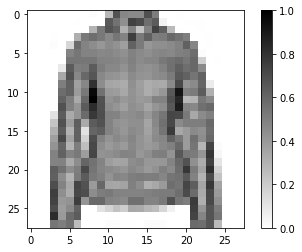

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

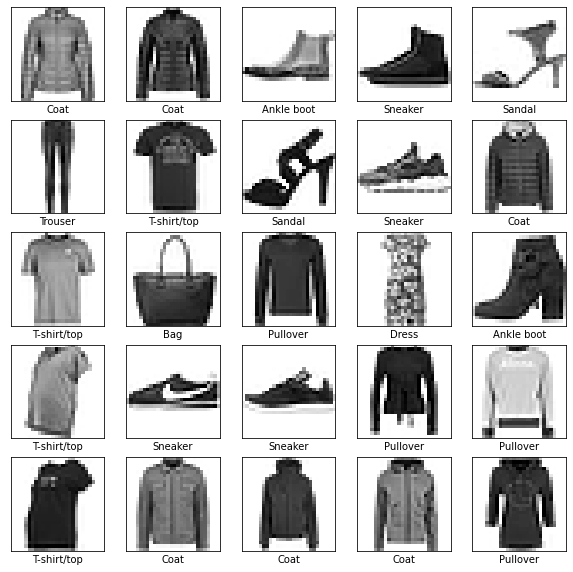

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3930 - accuracy: 0.8578
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2606 - accuracy: 0.9054
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2167 - accuracy: 0.9199
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1827 - accuracy: 0.9326
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1579 - accuracy: 0.9418
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1345 - accuracy: 0.9499
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1145 - accuracy: 0.9578
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0978 - accuracy: 0.9644
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0818 - accuracy: 0.9704
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.068

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 5ms/step - loss: 0.3140 - accuracy: 0.9189
Accuracy on test dataset: 0.9189000129699707


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
predictions.shape


(32, 10)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([2.5096245e-09, 1.4612886e-11, 9.9010544e-04, 1.8686242e-11,
       9.7670299e-01, 1.9827058e-10, 2.2306841e-02, 2.3934923e-11,
       1.3601242e-10, 4.8161358e-08], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

4

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

In [ ]:
test_labels[0]

4

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

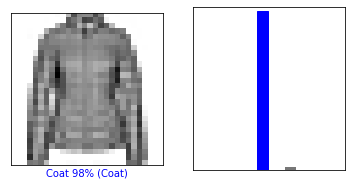

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

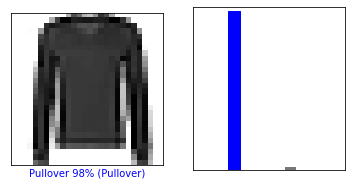

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

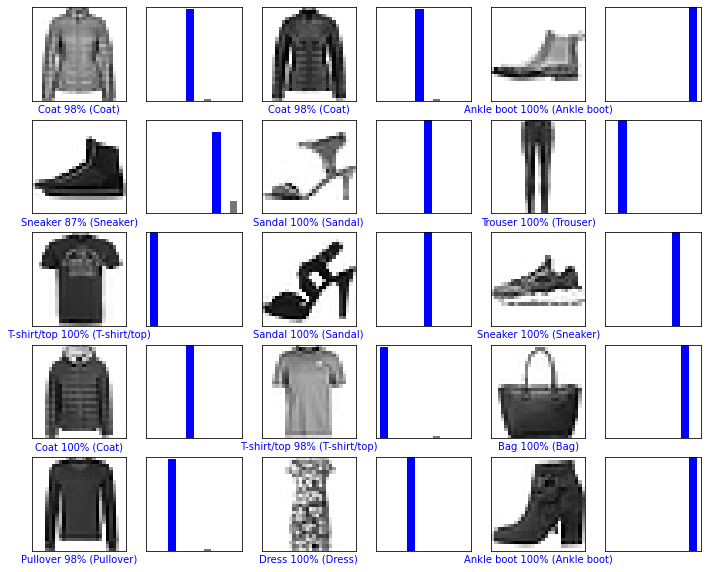

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.5096245e-09 1.4612913e-11 9.9010498e-04 1.8686280e-11 9.7670299e-01
  1.9827096e-10 2.2306841e-02 2.3935059e-11 1.3601294e-10 4.8161539e-08]]


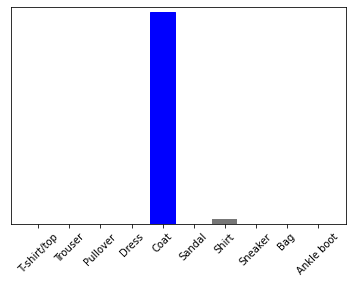

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

4

# EXPERIMENTATION

We experiment with different models and see how the accuracy results differ. In particular we will change the following parameters:
*   Setting training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, we go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Adding additional Dense layers between the Flatten and the final Dense(10, activation=tf.nn.softmax), experimenting with different units in these layers
*   Not normalizing the pixel values


We need to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).


--------------------------------------------

Let's first experiment on the number of epochs. We create the two same models.

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now train on different epochs.

In [ ]:
#set training epoch set to 1
model2.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
#set training epoch set to a larger number
model3.fit(train_dataset, epochs=30, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 [==============================] - 5s 3ms/step - loss: 0.3974 - accuracy: 0.8562
Epoch 1/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3916 - accuracy: 0.8582
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2594 - accuracy: 0.9061
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2120 - accuracy: 0.9215
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1830 - accuracy: 0.9320
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1558 - accuracy: 0.9414
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1322 - accuracy: 0.9516
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1113 - accuracy: 0.9581
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0980 - accuracy: 0.9640
Epoch 9/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0797 - accuracy

Model 1, 2 and 3 are the same, but we fit model 2 over 1 epoch and model 3 over 30 epochs instead of 10. We will now compare how the three models perform on the test dataset. Does a higher number of epochs improve accuracy?

In [ ]:
test_loss2, test_accuracy2 = model2.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
test_loss3, test_accuracy3 = model3.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

313/313 [==============================] - 1s 2ms/step - loss: 0.7468 - accuracy: 0.9134


In [ ]:
print('Accuracy of model 1 on test dataset:', test_accuracy)
print('Accuracy of model 2 on test dataset:', test_accuracy2)
print('Accuracy of model 3 on test dataset:', test_accuracy3)

Accuracy of model 1 on test dataset: 0.9189000129699707
Accuracy of model 2 on test dataset: 0.8895999789237976
Accuracy of model 3 on test dataset: 0.9133999943733215


Conclusion: Model 2 has lower accuracy than the model trained with 10 epochs, and might suffer from underfitting.
Although I suspected model 3 might suffer from overfitting, it actually has higher accuracy than model 1.

---------------------------------------------
Let's now experiment on the number of neurons. Could we expect a high number of neurons to increase accuracy?

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model 4 has only 10 neurons in the dense layer, while Model 5 has 512. We proceed to train and compare them as earlier.

In [ ]:
model4.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
model5.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7340 - accuracy: 0.7435
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3839 - accuracy: 0.8649
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3231 - accuracy: 0.8861
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2965 - accuracy: 0.8963
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2669 - accuracy: 0.9062
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2526 - accuracy: 0.9098
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2338 - accuracy: 0.9168
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2209 - accuracy: 0.9214
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2088 - accuracy: 0.9254
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.198

In [ ]:
test_loss4, test_accuracy4 = model4.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
test_loss5, test_accuracy5 = model5.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

313/313 [==============================] - 1s 2ms/step - loss: 0.3546 - accuracy: 0.9229


In [ ]:
print('Accuracy of model 1 on test dataset:', test_accuracy)
print('Accuracy of model 4 on test dataset:', test_accuracy4)
print('Accuracy of model 5 on test dataset:', test_accuracy5)

Accuracy of model 1 on test dataset: 0.9189000129699707
Accuracy of model 4 on test dataset: 0.9067000150680542
Accuracy of model 5 on test dataset: 0.9229000210762024


Conclusion: As expected, a high number of neurons as in model 5 does increase accuracy compared to model 1. A low number of neurons as in model 4 decreases accuracy, although not considerably.

-----------------------------------
As done in a previous assignment, we now want to compare configuration designs of Dense layers in our models. We take care to keep the same number of neurons.

In [ ]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model7 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model8 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(88, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the models:

In [ ]:
model6.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
model7.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
model8.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7657 - accuracy: 0.7080
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4571 - accuracy: 0.8343
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3728 - accuracy: 0.8656
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3389 - accuracy: 0.8781
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3058 - accuracy: 0.8907
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2797 - accuracy: 0.9003
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2629 - accuracy: 0.9064
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2492 - accuracy: 0.9114
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2329 - accuracy: 0.9164
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.220

In [ ]:
test_loss6, test_accuracy6 = model6.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
test_loss7, test_accuracy7 = model7.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
test_loss8, test_accuracy8 = model8.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

313/313 [==============================] - 1s 2ms/step - loss: 0.2888 - accuracy: 0.9156


In [ ]:
print('Accuracy of model 1 on test dataset:', test_accuracy)
print('Accuracy of model 6 on test dataset:', test_accuracy6)
print('Accuracy of model 7 on test dataset:', test_accuracy7)
print('Accuracy of model 8 on test dataset:', test_accuracy8)

Accuracy of model 1 on test dataset: 0.9189000129699707
Accuracy of model 6 on test dataset: 0.8970000147819519
Accuracy of model 7 on test dataset: 0.8919000029563904
Accuracy of model 8 on test dataset: 0.9156000018119812


Conclusion: For this specific training example, having a very high number of dense layers decreases accuracy. Models that perform the best are those with one (Model 1) or two (Model 8) dense layers. Indeed, as our problem is relatively simple, one or two linearly separable functions are enough.

------------------------------------
Finally, we go back to the datasets and remove normalization to see the effects it has on the efficiency of our model.

In [ ]:
#unnormalised data sets
train_dataset2, test_dataset2 = dataset['train'], dataset['test']

#Cache the images
train_dataset2 =  train_dataset2.cache()
test_dataset2  =  test_dataset2.cache()


def normalize2(images, labels):
  images = tf.cast(images, tf.float32)
  images = (images/255)**2
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset3, test_dataset3 = dataset['train'], dataset['test']
train_dataset3 =  train_dataset3.map(normalize2)
test_dataset3  =  test_dataset3.map(normalize2)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset3 =  train_dataset3.cache()
test_dataset3  =  test_dataset3.cache()

train_dataset2 = train_dataset2.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset2= test_dataset2.batch(BATCH_SIZE)

train_dataset3 = train_dataset3.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset3 = test_dataset3.batch(BATCH_SIZE)

In [ ]:
#Create new models based on model 1
model9 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model9.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model10 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model10.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Fit the models to the unnormalized dataset (model 9) and squared dataset (model 10):

In [ ]:
model9.fit(train_dataset2, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
model10.fit(train_dataset3, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5912 - accuracy: 0.8555
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2759 - accuracy: 0.8995
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2411 - accuracy: 0.9117
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2164 - accuracy: 0.9198
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1942 - accuracy: 0.9278
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1795 - accuracy: 0.9340
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1634 - accuracy: 0.9390
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1553 - accuracy: 0.9424
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1441 - accuracy: 0.9456
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.134

In [ ]:
test_loss9, test_accuracy9 = model9.evaluate(test_dataset2, steps=math.ceil(num_test_examples/32))
test_loss10, test_accuracy10 = model10.evaluate(test_dataset3, steps=math.ceil(num_test_examples/32))

313/313 [==============================] - 1s 3ms/step - loss: 0.3290 - accuracy: 0.9192


In [ ]:
print('Accuracy of model 1 on test dataset:', test_accuracy)
print('Accuracy of model 9 on test dataset:', test_accuracy9)
print('Accuracy of model 10 on test dataset:', test_accuracy10)

Accuracy of model 1 on test dataset: 0.9189000129699707
Accuracy of model 9 on test dataset: 0.9016000032424927
Accuracy of model 10 on test dataset: 0.9192000031471252


Conclusion: unnormalized or squared data sets seem to lead to less accurate trainings, as model 1 once more performs best.

------------------------
------------------------

Conclusion:

Of our 10 models, models 1, 8, 5 and 3 seem to perform best. We could assume an ideal model for our problem would have not too many dense layers (Model 8) with many neurons (Model 5) and would be trained over a moderately high number of epochs (Model 3).